<a href="https://colab.research.google.com/github/HEsiyun/nlp-project-draft/blob/main/BERT_batch32_lr3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Nov 29 22:19:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
# load the dataframe from csv
import pandas as pd
df = pd.read_csv('data.csv')
df.head()

,id,review_body,label
0,1558703,Waste of money: Save your money it's not worth...,0
1,4508221,"The book was interesting, Dr Dyer is a very ta...",1
2,1037943,painted bulb: Clear yellow glass would be nice...,0
3,12701540,I have only had the battery for a week and it ...,1
4,491373,Not this time: I adored Liz Ireland's previous...,0


In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.optim import AdamW
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import random

# Set the seed for Python's built-in random module
random.seed(42)

# Set the seed for NumPy
np.random.seed(42)

# Set the seed for PyTorch
torch.manual_seed(42)

# Set the seed for CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # situation when using multi-GPU.

# Load data from csv file
data = pd.read_csv('data.csv')

# Split the data
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# Define a custom dataset
class ReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        review = str(self.data.iloc[index, 1])
        label = self.data.iloc[index, 2]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-cased',  # Specify the pre-trained model
    padding_side='right',  # Ensure padding is added on the right side
    truncation=True  # Default truncation is enabled
)
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)

# Create data loaders
train_dataset = ReviewDataset(train_df, tokenizer, max_len=150)
val_dataset = ReviewDataset(val_df, tokenizer, max_len=150)
test_dataset = ReviewDataset(test_df, tokenizer, max_len=150)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=3e-5)

# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)

from tqdm import tqdm
import torch

def train_epoch(model, data_loader, optimizer, device):
    model = model.train()  # Set model to training mode

    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Iterate over the batches in data_loader with tqdm for progress
    for batch in tqdm(data_loader, desc="Training", unit="batch"):
        optimizer.zero_grad()

        # Send batch data to the device (GPU or CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        # Get predicted class by taking the class with the highest logit value
        _, preds = torch.max(logits, dim=1)

        # Accumulate correct predictions and total predictions for accuracy
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

        # Backward pass to compute gradients
        loss.backward()
        optimizer.step()

    # Calculate average loss and accuracy over the entire epoch
    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions / total_predictions

    return avg_loss, avg_accuracy

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).flatten()

            loss = loss_fn(logits, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = correct_predictions.double() / n_examples
    avg_loss = np.mean(losses)
    report = classification_report(true_labels, predictions, zero_division=0)

    return accuracy, avg_loss, report


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from collections import defaultdict

def train_epoch(model, data_loader, optimizer, device, batch_log_interval=100):
    model = model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch_idx, batch in enumerate(tqdm(data_loader, desc="Training", unit="batch")):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

        loss.backward()
        optimizer.step()

        # Print metrics every batch_log_interval batches
        if (batch_idx + 1) % batch_log_interval == 0:
            avg_loss = total_loss / (batch_idx + 1)
            avg_accuracy = correct_predictions / total_predictions
            print(f'Batch {batch_idx + 1}/{len(data_loader)} - Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions / total_predictions

    return avg_loss, avg_accuracy

# Adjust the training loop for early stopping based on batches
history = defaultdict(list)
best_accuracy = 0
patience = 200  # Number of batches to wait for improvement
early_stopping_counter = 0

epochs = 3
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    print('-' * 10)

    train_loss, train_accuracy = train_epoch(model, train_loader, optimizer, device)

    val_accuracy, val_loss, val_report = eval_model(model, val_loader, loss_fn, device, len(val_loader.dataset))
    print(f'Validation loss: {val_loss} accuracy: {val_accuracy}')
    print(val_report)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_accuracy)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_accuracy)

    if val_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_accuracy
        early_stopping_counter = 0
    else:
        early_stopping_counter += len(train_loader)  # Increment by number of batches

    if early_stopping_counter >= patience:
        print("Early stopping triggered")
        break

Epoch 1/3
----------


Training:   9%|▉         | 101/1085 [00:19<02:51,  5.73batch/s]

Batch 100/1085 - Loss: 0.4057, Accuracy: 0.8128


Training:  19%|█▊        | 201/1085 [00:36<02:33,  5.74batch/s]

Batch 200/1085 - Loss: 0.3569, Accuracy: 0.8458


Training:  28%|██▊       | 301/1085 [00:54<02:16,  5.72batch/s]

Batch 300/1085 - Loss: 0.3312, Accuracy: 0.8593


Training:  37%|███▋      | 401/1085 [01:11<01:59,  5.73batch/s]

Batch 400/1085 - Loss: 0.3160, Accuracy: 0.8679


Training:  46%|████▌     | 501/1085 [01:28<01:41,  5.73batch/s]

Batch 500/1085 - Loss: 0.3031, Accuracy: 0.8738


Training:  55%|█████▌    | 601/1085 [01:46<01:24,  5.74batch/s]

Batch 600/1085 - Loss: 0.2954, Accuracy: 0.8773


Training:  65%|██████▍   | 701/1085 [02:03<01:07,  5.73batch/s]

Batch 700/1085 - Loss: 0.2896, Accuracy: 0.8810


Training:  74%|███████▍  | 801/1085 [02:21<00:49,  5.73batch/s]

Batch 800/1085 - Loss: 0.2841, Accuracy: 0.8838


Training:  83%|████████▎ | 901/1085 [02:38<00:32,  5.74batch/s]

Batch 900/1085 - Loss: 0.2796, Accuracy: 0.8854


Training:  92%|█████████▏| 1001/1085 [02:56<00:14,  5.73batch/s]

Batch 1000/1085 - Loss: 0.2763, Accuracy: 0.8875


Training: 100%|██████████| 1085/1085 [03:11<00:00,  5.68batch/s]


Validation loss: 0.24482374509577365 accuracy: 0.9010836984090386
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      2185
           1       0.89      0.92      0.90      2152

    accuracy                           0.90      4337
   macro avg       0.90      0.90      0.90      4337
weighted avg       0.90      0.90      0.90      4337

Epoch 2/3
----------


Training:   9%|▉         | 101/1085 [00:17<02:51,  5.74batch/s]

Batch 100/1085 - Loss: 0.1585, Accuracy: 0.9400


Training:  19%|█▊        | 201/1085 [00:35<02:34,  5.74batch/s]

Batch 200/1085 - Loss: 0.1628, Accuracy: 0.9381


Training:  28%|██▊       | 301/1085 [00:52<02:16,  5.74batch/s]

Batch 300/1085 - Loss: 0.1619, Accuracy: 0.9374


Training:  37%|███▋      | 401/1085 [01:09<01:59,  5.74batch/s]

Batch 400/1085 - Loss: 0.1618, Accuracy: 0.9370


Training:  46%|████▌     | 501/1085 [01:27<01:41,  5.74batch/s]

Batch 500/1085 - Loss: 0.1625, Accuracy: 0.9366


Training:  55%|█████▌    | 601/1085 [01:44<01:24,  5.74batch/s]

Batch 600/1085 - Loss: 0.1634, Accuracy: 0.9369


Training:  65%|██████▍   | 701/1085 [02:02<01:06,  5.73batch/s]

Batch 700/1085 - Loss: 0.1660, Accuracy: 0.9365


Training:  74%|███████▍  | 801/1085 [02:19<00:49,  5.73batch/s]

Batch 800/1085 - Loss: 0.1676, Accuracy: 0.9366


Training:  83%|████████▎ | 901/1085 [02:37<00:32,  5.74batch/s]

Batch 900/1085 - Loss: 0.1679, Accuracy: 0.9365


Training:  92%|█████████▏| 1001/1085 [02:54<00:14,  5.70batch/s]

Batch 1000/1085 - Loss: 0.1686, Accuracy: 0.9360


Training: 100%|██████████| 1085/1085 [03:09<00:00,  5.73batch/s]


Validation loss: 0.25536824536838515 accuracy: 0.9073091999077704
              precision    recall  f1-score   support

           0       0.92      0.89      0.91      2185
           1       0.89      0.92      0.91      2152

    accuracy                           0.91      4337
   macro avg       0.91      0.91      0.91      4337
weighted avg       0.91      0.91      0.91      4337

Epoch 3/3
----------


Training:   9%|▉         | 101/1085 [00:17<02:51,  5.72batch/s]

Batch 100/1085 - Loss: 0.1013, Accuracy: 0.9678


Training:  19%|█▊        | 201/1085 [00:35<02:34,  5.73batch/s]

Batch 200/1085 - Loss: 0.0871, Accuracy: 0.9717


Training:  28%|██▊       | 301/1085 [00:52<02:16,  5.74batch/s]

Batch 300/1085 - Loss: 0.0894, Accuracy: 0.9704


Training:  37%|███▋      | 401/1085 [01:10<01:59,  5.74batch/s]

Batch 400/1085 - Loss: 0.0880, Accuracy: 0.9704


Training:  46%|████▌     | 501/1085 [01:27<01:41,  5.74batch/s]

Batch 500/1085 - Loss: 0.0921, Accuracy: 0.9689


Training:  55%|█████▌    | 601/1085 [01:44<01:24,  5.73batch/s]

Batch 600/1085 - Loss: 0.0937, Accuracy: 0.9683


Training:  65%|██████▍   | 701/1085 [02:02<01:07,  5.73batch/s]

Batch 700/1085 - Loss: 0.0936, Accuracy: 0.9682


Training:  74%|███████▍  | 801/1085 [02:19<00:49,  5.73batch/s]

Batch 800/1085 - Loss: 0.0941, Accuracy: 0.9679


Training:  83%|████████▎ | 901/1085 [02:37<00:32,  5.74batch/s]

Batch 900/1085 - Loss: 0.0964, Accuracy: 0.9668


Training:  92%|█████████▏| 1001/1085 [02:54<00:14,  5.74batch/s]

Batch 1000/1085 - Loss: 0.0967, Accuracy: 0.9662


Training: 100%|██████████| 1085/1085 [03:09<00:00,  5.73batch/s]


Validation loss: 0.3309650587890407 accuracy: 0.9033894397048652
              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2185
           1       0.90      0.90      0.90      2152

    accuracy                           0.90      4337
   macro avg       0.90      0.90      0.90      4337
weighted avg       0.90      0.90      0.90      4337

Early stopping triggered


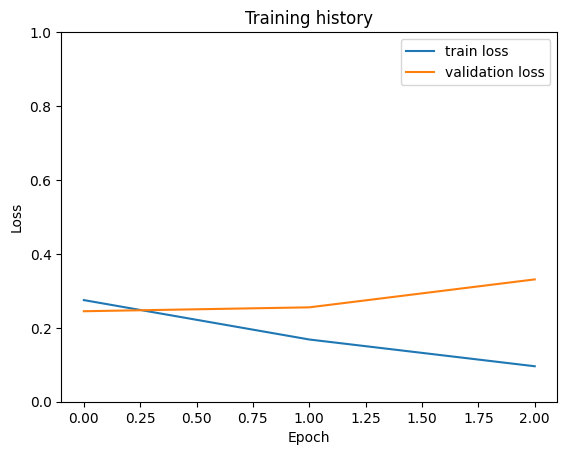

In [ ]:
import matplotlib.pyplot as plt
# Clear any previous plot if there is one
plt.clf()

if isinstance(history['train_loss'], list):
    history['train_loss'] = torch.tensor(history['train_loss'])

if isinstance(history['val_loss'], list):
    history['val_loss'] = torch.tensor(history['val_loss'])

train_loss = history['train_loss'].cpu().numpy()
val_loss = history['val_loss'].cpu().numpy()

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

plt.show()

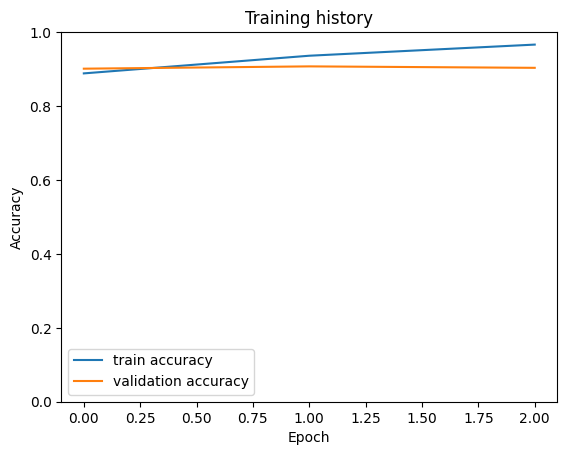

In [ ]:
import matplotlib.pyplot as plt
# Clear any previous plot if there is one
plt.clf()

if isinstance(history['train_acc'], list):
    history['train_acc'] = torch.tensor(history['train_acc'])

if isinstance(history['val_acc'], list):
    history['val_acc'] = torch.tensor(history['val_acc'])


train_acc = history['train_acc'].cpu().numpy()
val_acc = history['val_acc'].cpu().numpy()


plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

plt.show()

In [8]:
# Get the accuracy score on test dataset
test_acc, _, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_df)
)

test_acc.item()

0.906848051648605

In [7]:
import torch.nn.functional as F

def get_predictions(model, data_loader, device):
    model = model.eval()  # Set the model to evaluation mode

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():  # Disable gradient calculation
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Get predicted class by taking the class with the highest logit value
            _, preds = torch.max(logits, dim=1)

            # Calculate probabilities using softmax
            probs = F.softmax(logits, dim=1)

            # Collect results
            review_texts.extend(texts)
            predictions.extend(preds.cpu().numpy())
            prediction_probs.extend(probs.cpu().numpy())
            real_values.extend(labels.cpu().numpy())

    return review_texts, predictions, prediction_probs, real_values

# Use the function to get predictions
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader, device)

# Print classification report
# print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Test loss: 0.3106519925846335 accuracy: 0.906848051648605
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2204
           1       0.91      0.91      0.91      2133

    accuracy                           0.91      4337
   macro avg       0.91      0.91      0.91      4337
weighted avg       0.91      0.91      0.91      4337



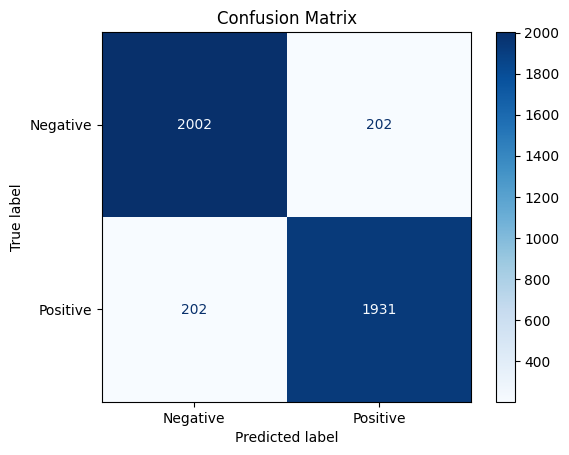

In [9]:
# Generate the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

test_accuracy, test_loss, test_report = eval_model(model, test_data_loader, loss_fn, device, len(test_data_loader.dataset))
print(f'Test loss: {test_loss} accuracy: {test_accuracy}')
print(test_report)

#  binary classification with labels 0 and 1
class_names = ['Negative', 'Positive']

plot_confusion_matrix(y_test, y_pred, class_names)

In [10]:

from sklearn.metrics import roc_curve, auc
y_pred_probs_positive = [prob[1] for prob in y_pred_probs]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs_positive)

# Calculate AUC
roc_auc = auc(fpr, tpr)

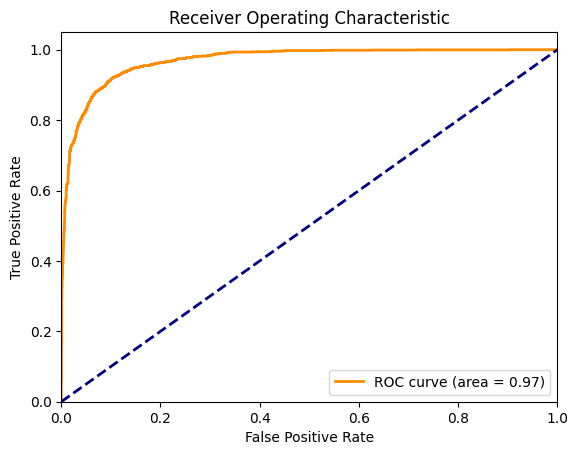

In [11]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()